In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating Dataframes by Loading CSV Files

In [2]:
df_mbpp = pd.read_csv('measurements_mbpp.csv')
df_mbpp.head()

,LLM,Benchmark prompt,Execution time (s),CPU Energy (J),RAM Energy (J),GPU Energy (J),CPU Power (W),RAM Power (W),GPU Power (W),CO2 emissions (Kg),CO2 emissions rate (Kg/s),MBPP+ pass@1
0,llama-2-7b.Q2_K,Mbpp/2,27.474275,618.151610,149.778231,-36.356029,22.5,5.794056,26.037183,0.000045,1.620237e-06,0.037
1,llama-2-7b.Q2_K,Mbpp/3,27.225289,612.561108,148.171252,-57.004046,22.5,5.794056,27.617270,0.000043,1.572821e-06,0.037
2,llama-2-7b.Q2_K,Mbpp/4,43.174038,971.403226,240.597236,229.255183,22.5,5.794056,24.876322,0.000088,2.031258e-06,0.037
3,llama-2-7b.Q2_K,Mbpp/6,16.692756,375.577766,87.136298,-292.893234,22.5,5.794056,0.000000,0.000010,6.190270e-07,0.037
4,llama-2-7b.Q2_K,Mbpp/7,13.824301,311.043726,80.090345,241.476193,22.5,5.794056,17.468861,0.000038,2.784452e-06,0.037


### Calculating mean values for MBPP+

In [8]:
#TODO: Quando tiver várias execuções de um dado prompt, remover os outliers de cada medição

# Define a custom function to remove outliers and specified number of best and worst entries
def remove_extremes(group, n):
    sorted_group = group.sort_values(by='CPU Energy (J)')
    trimmed_group = sorted_group.iloc[n:-n]  # Remove the specified number of best and worst entries
    return trimmed_group

# Grouping by 'LLM' and 'Benchmark prompt' and applying the custom function
n_outliers = 1  # Number of outliers to remove
cleaned_df_mbpp = df_mbpp.groupby(['LLM'], group_keys=False).apply(remove_extremes, n=n_outliers).reset_index(drop=True)

# Calculating the mean values for 'CPU Energy (J)' and 'MBPP' after removing extremes
mean_cleaned_df_mbpp = cleaned_df_mbpp.groupby(['LLM']).agg(
    {
        'CPU Energy (J)': 'mean', 
        'Execution time (s)': 'mean', 
        'MBPP+ pass@1': 'mean'
    }).reset_index()

# Renaming the columns for clarity
mean_cleaned_df_mbpp.columns = ['LLM', 'CPU Energy (J)', 'Execution time (s)', 'MBPP+ pass@1']
mean_cleaned_df_mbpp



,LLM,CPU Energy (J),Execution time (s),MBPP+ pass@1
0,llama-2-7b.Q2_K,703.598573,31.271554,0.037
1,llama-2-7b.Q3_K_L,761.106073,33.827484,0.042


In [7]:
# NOTE: Este dataframe serve apenas para testar a criação dos gráficos de comparação entre 0-shot e n-shot prompting
# Função para aumentar em 1 todas as variáveis numéricas
def aumentar_em_um(x):
    if pd.api.types.is_numeric_dtype(x):
        if x.name == 'MBPP+ pass@1':
            return x + 0.25
        else:
            return x + 1
    else:
        return x

# Aplicar a função ao DataFrame
df_n_shot = mean_cleaned_df_mbpp.apply(aumentar_em_um)
df_n_shot

,LLM,CPU Energy (J),Execution time (s),MBPP+ pass@1
0,llama-2-7b.Q2_K,704.598573,32.271554,0.287
1,llama-2-7b.Q3_K_L,762.106073,34.827484,0.292


### MBBP graphs

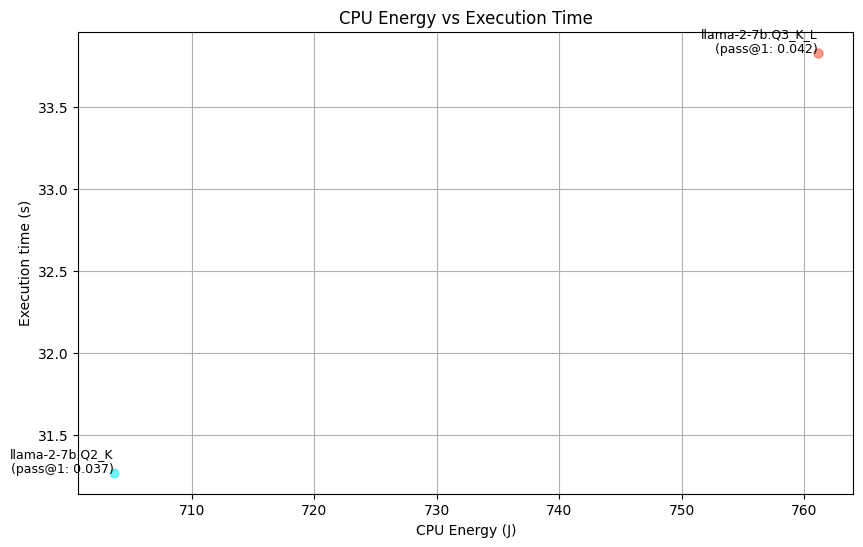

In [6]:
import numpy as np

# Cores aleatórias para cada LLM
llm_colors = {llm: np.random.rand(3,) for llm in mean_cleaned_df_mbpp["LLM"]}

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
for i, llm in enumerate(mean_cleaned_df_mbpp["LLM"]):
    plt.scatter(mean_cleaned_df_mbpp["CPU Energy (J)"][i], mean_cleaned_df_mbpp["Execution time (s)"][i], color=llm_colors[llm], s=mean_cleaned_df_mbpp["MBPP+ pass@1"][i] * 1000, alpha=0.7)
    plt.text(mean_cleaned_df_mbpp["CPU Energy (J)"][i], mean_cleaned_df_mbpp["Execution time (s)"][i], f'{llm}\n(pass@1: {mean_cleaned_df_mbpp["MBPP+ pass@1"][i]})', fontsize=9, ha='right')

# Adicionar rótulos e título
plt.xlabel('CPU Energy (J)')
plt.ylabel('Execution time (s)')
plt.title('CPU Energy vs Execution Time')

# Mostrar o gráfico
plt.grid(True)
plt.show()

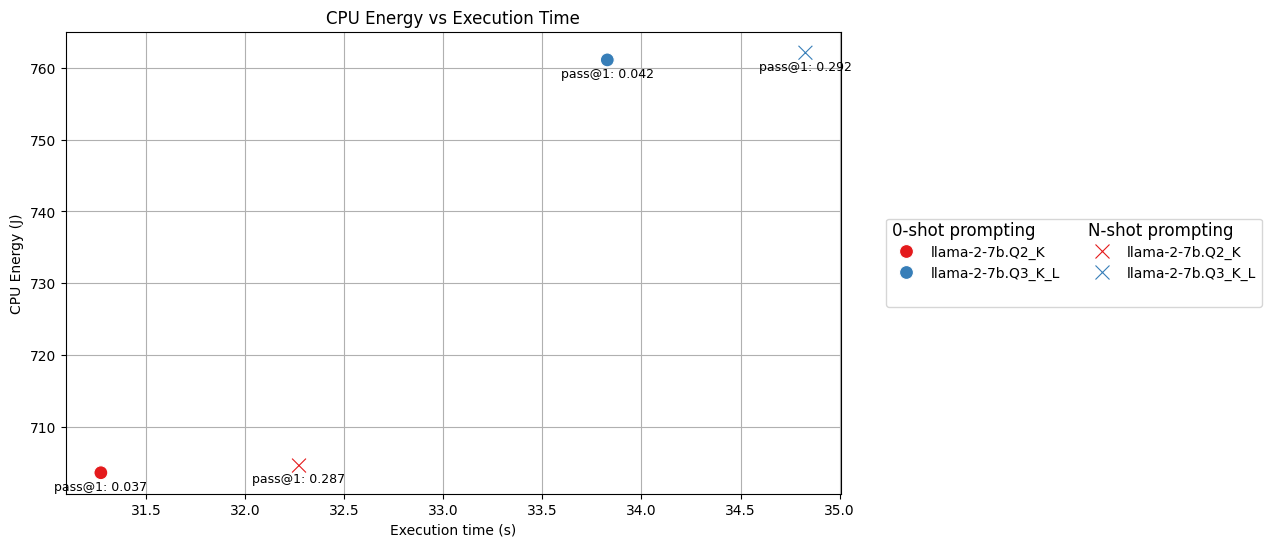

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.text as mtext

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Plot do primeiro dataframe (0-shot prompting)
scatter1 = sns.scatterplot(data=mean_cleaned_df_mbpp, x="Execution time (s)", y="CPU Energy (J)", hue="LLM", palette='Set1', s=100)
scatter2 = sns.scatterplot(data=df_n_shot, x="Execution time (s)", y="CPU Energy (J)", hue="LLM", palette='Set1', s=100, marker='x')

# Adicionar rótulos e título
plt.xlabel('Execution time (s)')
plt.ylabel('CPU Energy (J)')
plt.title('CPU Energy vs Execution Time')

# Adicionar legenda
handles, labels = plt.gca().get_legend_handles_labels()  # Obter identificadores da legenda

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title

elements_per_column = 2

# Adicionando títulos personalizados à legenda
legend = plt.legend(['0-shot prompting'] + handles[:elements_per_column] + ['','N-shot prompting'] + handles[elements_per_column:], 
                    [''] + labels[:elements_per_column] + ['',''] + labels[elements_per_column:],
                    handler_map={str: LegendTitle({'fontsize': 12})},
                    bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

# Adicionar valores de pass@1 em baixo de cada bola
for index, row in mean_cleaned_df_mbpp.iterrows():
    scatter1.text(row['Execution time (s)'], row['CPU Energy (J)']-1, f"pass@1: {row['MBPP+ pass@1']}", fontsize=9, ha='center', va='top')

for index, row in df_n_shot.iterrows():
    scatter2.text(row['Execution time (s)'], row['CPU Energy (J)']-1, f"pass@1: {row['MBPP+ pass@1']}", fontsize=9, ha='center', va='top')

# Mostrar o gráfico
plt.grid(True)
plt.show()
